In [122]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import torch
import random
import matplotlib.pyplot as plt

## 线性回归的从零开始实现

### 1、生成数据集

In [123]:
def synthetic_data(w, b, num_examples):
    x = torch.normal(0,1,(num_examples,2))
    y = torch.matmul(x,w)+b
    y += torch.normal(0,0.01,y.shape) # 保证相加的时候维度不会变化
    return x,y.reshape(-1,1)

In [124]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)
print(f'features.shape:\t{features.shape}')
print(f'labels.shape:\t{labels.shape}')
print(f'features[0]:\t{features[0]}')
print(f'labels[0]:\t{labels[0]}')

features.shape:	torch.Size([1000, 2])
labels.shape:	torch.Size([1000, 1])
features[0]:	tensor([0.1084, 0.3534])
labels[0]:	tensor([3.2099])


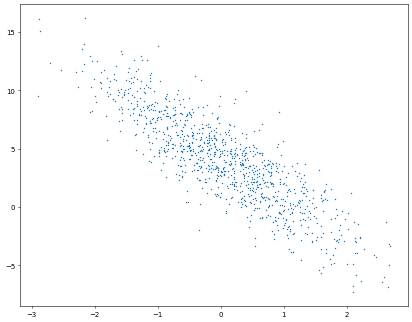

In [125]:
plt.figure(figsize=(10,8),dpi=50)
plt.scatter(features[:,1].detach().numpy(),labels.detach().numpy(),1)
plt.show()

### 2、读取数据集

In [126]:
# 定义data_iter函数，该函数接受不了批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量，每个小批量包含一组特征和标签
def data_iter(batch_size,features,labels):
    num_example = len(features)
    indices = list(range(num_example))
    random.shuffle(indices)
    for i in range(0,num_example,batch_size):
        batch_indices = indices[i:min(num_example,i+batch_size)]
        yield features[batch_indices],labels[batch_indices]

In [127]:
batch_size=10
for x,y in data_iter(batch_size,features,labels):
    print(x,'\n',y)
    break

tensor([[-0.7832,  0.5526],
        [-0.0069, -1.9208],
        [ 0.5610, -0.7585],
        [ 0.4656, -1.0934],
        [-0.5263,  1.0028],
        [ 0.8885,  0.3069],
        [-1.0490,  1.6692],
        [-1.6016, -0.6124],
        [ 1.4557,  1.6659],
        [ 0.7772, -0.1044]]) 
 tensor([[ 0.7684],
        [10.7331],
        [ 7.9024],
        [ 8.8449],
        [-0.2791],
        [ 4.9365],
        [-3.5657],
        [ 3.0666],
        [ 1.4339],
        [ 6.1161]])


### 3、初始化模型参数

In [128]:
w = torch.normal(0,1,size=(2,1),requires_grad=True)
b = torch.zeros(1,requires_grad=True)

### 4、定义模型

In [129]:
def linreg(x,w,b):
    return torch.matmul(x,w)+b

### 5、定义损失函数

In [130]:
def squard_loss(y_hat,y):
    return (y_hat-y.reshape(y_hat.shape))**2/2

### 6、定义优化算法

In [131]:
def sgd(params,lr,batch_size):
    with torch.no_grad(): # 不用反向跟踪记录梯度
        for param in params:
            param -= lr * param.grad / batch_size # 参数更新
            param.grad.zero_() # 参数梯度归零

### 7、训练

In [132]:
lr = 0.03
num_epochs = 3
batch_size = 16
net = linreg
loss = squard_loss

In [133]:
for epoch in range(num_epochs):
    for x,y in data_iter(batch_size,features,labels):
        y_hat = net(x, w, b) # 前向传播
        losses = loss(y_hat, y) # 计算损失函数
        losses.sum().backward() # 反向传播
        sgd([w, b], lr, batch_size) # 参数更新

    with torch.no_grad():
        train_loss = loss(net(features,w,b),labels).mean()
        print(f'train_loss:{train_loss:.4f}')


train_loss:0.4485
train_loss:0.0129
train_loss:0.0004


In [134]:
print(f'w的估计误差:{true_w-w}')
print(f'b的估计误差:{true_b-b}')

w的估计误差:tensor([[ 0.0112, -5.3888],
        [ 5.3840, -0.0160]], grad_fn=<SubBackward0>)
b的估计误差:tensor([0.0187], grad_fn=<RsubBackward1>)


## 线性回归的简洁实现

In [135]:
import numpy as np
import torch
from torch.utils import data
from torch import nn

### 1、生成数据集

In [136]:
true_w = torch.tensor([2,-3.4])
true_b = 4.2
features,labels = synthetic_data(true_w,true_b,1000)

### 2、读取数据集

In [137]:
def load_array(data_arrays,batch_size,is_train=True):
    dataset = data.TensorDataset(*data_arrays) # data_arrays是元祖需要解包
    dataloader = data.DataLoader(dataset,batch_size,shuffle=is_train)
    return dataloader

In [138]:
batch_size = 10
data_iter = load_array((features,labels),batch_size)

In [139]:
next(iter(data_iter))

[tensor([[-0.3113, -0.2841],
         [-0.6730,  0.4201],
         [-0.6661, -0.0830],
         [-0.3867,  1.3824],
         [-0.0379, -0.7079],
         [ 0.4328,  0.6350],
         [ 1.4333,  0.5242],
         [ 1.0616,  0.1431],
         [ 1.9427, -0.7971],
         [-0.9898, -1.8904]]),
 tensor([[ 4.5402],
         [ 1.4148],
         [ 3.1637],
         [-1.2577],
         [ 6.5270],
         [ 2.9033],
         [ 5.2678],
         [ 5.8361],
         [10.8121],
         [ 8.6550]])]

### 3、定义模型

In [140]:
net = nn.Sequential(nn.Linear(2,1))

### 4、初始化模型参数

In [141]:
net[0].weight.data.normal_(0,0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### 5、定义损失函数

In [142]:
loss = nn.MSELoss()

### 6、定义优化算法

In [143]:
trainer = torch.optim.SGD(net.parameters(),lr=0.03)

### 7、训练

In [144]:
num_epochs = 3
for epoch in range(num_epochs):
    for x,y in data_iter:
        y_hat = net(x) # 前向传播
        l = loss(y,y_hat) # 计算损失
        trainer.zero_grad() # 清空梯度
        l.backward() # 反向传播
        trainer.step() # 更新参数
    l = loss(net(features),labels)
    print(f'epoch {epoch+1}, loss {l:f}')

epoch 1, loss 0.000264
epoch 2, loss 0.000099
epoch 3, loss 0.000099


In [145]:
w = net[0].weight.data
b = net[0].bias.data
print(f'w的估计误差:\t{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差:\t{true_b-b}')

w的估计误差:	tensor([-6.1750e-05,  3.2306e-04])
b的估计误差:	tensor([-0.0001])
